## Intro

![understat.JPG](images/understat.JPG)

In this notebook I will describe the process of scraping data from web portal [understat.com](https://understat.com) that has a lot of statistical information about all games in top 5 European football leagues.

From [understat.com](https://understat.com) home page:

* Expected goals (xG) is the new revolutionary football metric, which allows you to evaluate team and player performance.

* In a low-scoring game such as football, final match score does not provide a clear picture of performance.

* This is why more and more sports analytics turn to the advanced models like xG, which is a statistical measure of the quality of chances created and conceded.

* Our goal was to create the most precise method for shot quality evaluation.

* For this case, we trained neural network prediction algorithms with the large dataset (>100,000 shots, over 10 parameters for each).

* On this site, you will find our detailed xG statistics for the top European leagues.

At this moment they have not only xG metric, but much more, that makes this site perfect for scraping statistical data about football games.




We start by importing libraries that will be used in this project:
* numpy - fundamental package for scientific computing with Python
* pandas - library providing high-performance, easy-to-use data structures and data analysis tools
* requests - is the only Non-GMO HTTP library for Python, safe for human consumption. (love this line from official docs :D)
* BeautifulSoup - a Python library for pulling data out of HTML and XML files.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
from bs4 import BeautifulSoup

## Website research and structure of data

On the home page we can notice that the site has data for 6 European Leagues:

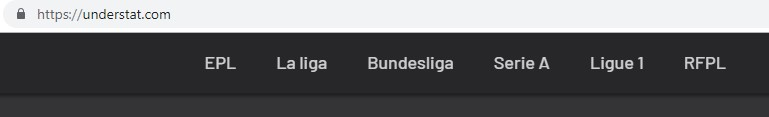

*   La Liga
*   EPL
*   BundesLiga
*   Serie A
*   Ligue 1
*   RFPL

And we also see that the collected starting from season 2014/2015. Another notion we make is the structure of URL. It is '`https://understat.com/league'` + '`/name_of_the_league`' + '`/year_start_of_the_season`'

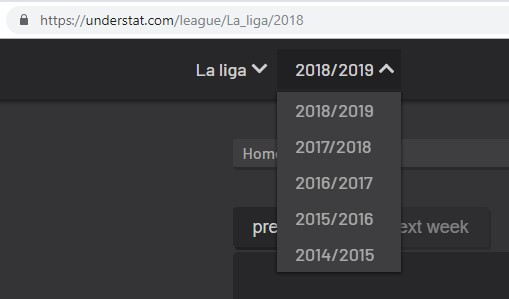

So we create global variables with this data to be able to select any of those.

In [2]:
# create urls for all seasons of all leagues
base_url = 'https://understat.com/league'
leagues = ['La_liga', 'EPL', 'Bundesliga', 'Serie_A', 'Ligue_1', 'RFPL']
seasons = ['2014', '2015', '2016', '2017', '2018']

Next step is to understan where the data is located on the web-page. For this we open Developer Tools in Chrome, go to tab "Network", find file with data (in this case 2018) and check the "Response" tab. This is what we will get after running *requests.get(URL)*

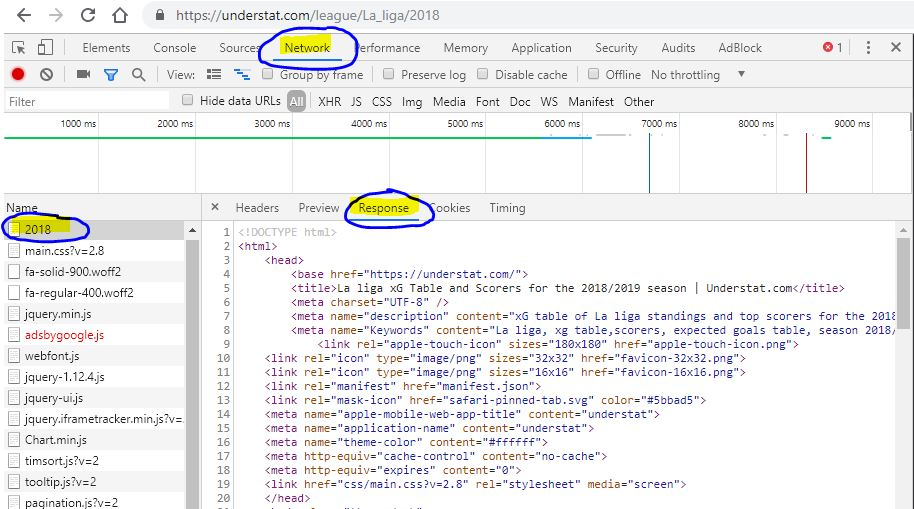

After going through content of the web-page we find that the data is stored under "script" tag and it is JSON encoded. So we will need to find this tag, get JSON from it and convert it into Python readable data structure.

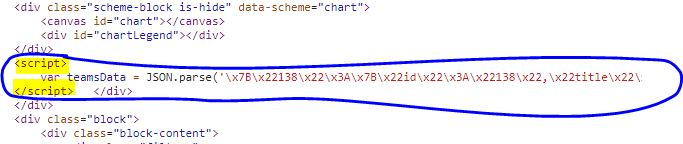

In [3]:
# Starting with latest data for Spanish league, because I'm a Barcelona fan
url = base_url+'/'+leagues[0]+'/'+seasons[4]
res = requests.get(url)
soup = BeautifulSoup(res.content, "lxml")

# Based on the structure of the webpage, I found that data is in the JSON variable, under <script> tags
scripts = soup.find_all('script')

# Check our <script> tags
# for el in scripts:
#   print('*'*50)
#   print(el.text)

### Working with JSON

We found that the data interesting us is stored in teamsData variable, after creating a soup of html tags it becomes just a string, so we find that text and extract JSON from it.

In [4]:
import json

string_with_json_obj = ''

# Find data for teams
for el in scripts:
    if 'teamsData' in el.text:
      string_with_json_obj = el.text.strip()
      
# print(string_with_json_obj)

# strip unnecessary symbols and get only JSON data
ind_start = string_with_json_obj.index("('")+2
ind_end = string_with_json_obj.index("')")
json_data = string_with_json_obj[ind_start:ind_end]

json_data = json_data.encode('utf8').decode('unicode_escape')

Once we have gotten our JSON and cleaned it up we can convert it into Python dictionary and check how it looks (uncomment print statement to do that).

### Understanding data with Python

In [5]:
# convert JSON data into Python dictionary
data = json.loads(json_data)
print(data.keys())
print('='*50)
print(data['138'].keys())
print('='*50)
print(data['138']['id'])
print('='*50)
print(data['138']['title'])
print('='*50)
print(data['138']['history'][0])

# Print pretty JSON data to check out what we have there
# s = json.dumps(data, indent=4, sort_keys=True)
# print(s)

dict_keys(['138', '140', '141', '142', '143', '145', '146', '147', '148', '150', '151', '152', '153', '154', '156', '158', '159', '223', '231', '232'])
dict_keys(['id', 'title', 'history'])
138
Sevilla
{'h_a': 'a', 'xG': 3.34997, 'xGA': 2.39239, 'npxG': 3.34997, 'npxGA': 1.64976, 'ppda': {'att': 252, 'def': 19}, 'ppda_allowed': {'att': 263, 'def': 20}, 'deep': 12, 'deep_allowed': 5, 'scored': 4, 'missed': 1, 'xpts': 1.9829999999999999, 'result': 'w', 'date': '2018-08-19 21:15:00', 'wins': 1, 'draws': 0, 'loses': 0, 'pts': 3, 'npxGD': 1.70021}


If you want to check how the entire <code>data</code> looks, just uncomment respective lines. (it is commented for the sake of saving screen space and do not oversaturate the view of notebook).

When we start to research the <code>data</code> we understand that this is a dictionary of dictionaries of 3 keys: *`id`*, *`title`* and *`history`*. The first layer of dictionary uses ids as keys too.

Also from this we understand that *`history`* has data regarding every single match the team played in its own league (League Cup or Champions League games are not included).

We can gather teams names if go over the first layer dictionary.

In [6]:
# Get teams and their relevant ids and put them into separate dictionary
teams = {}
for id in data.keys():
  teams[id] = data[id]['title']

The *`history`* is the array of dictionaries where keys are names of metrics (read column names) and values are values, despite how tautological is that :D.

We understand that column names repeat over and over again so we add them to separate list. Also checking how the sample values look like.

In [7]:
# EDA to get a feeling of how the JSON is structured
# Column names are all the same, so we just use first element
columns = []
# Check the sample of values per each column
values = []
for id in data.keys():
  columns = list(data[id]['history'][0].keys())
  values = list(data[id]['history'][0].values())
  break

print(columns)
print(values)

['h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'ppda', 'ppda_allowed', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'result', 'date', 'wins', 'draws', 'loses', 'pts', 'npxGD']
['a', 3.34997, 2.39239, 3.34997, 1.64976, {'att': 252, 'def': 19}, {'att': 263, 'def': 20}, 12, 5, 4, 1, 1.9829999999999999, 'w', '2018-08-19 21:15:00', 1, 0, 0, 3, 1.70021]


Found that Sevilla has the id=138, so getting all the data for this team to be able to reproduce the same steps for all teams in the league.

In [8]:
sevilla_data = []
for row in data['138']['history']:
  sevilla_data.append(list(row.values()))
  
df = pd.DataFrame(sevilla_data, columns=columns)
df.head(2)

,h_a,xG,xGA,npxG,npxGA,ppda,ppda_allowed,deep,deep_allowed,scored,missed,xpts,result,date,wins,draws,loses,pts,npxGD
0,a,3.34997,2.392390,3.34997,1.649760,"{'att': 252, 'def': 19}","{'att': 263, 'def': 20}",12,5,4,1,1.9830,w,2018-08-19 21:15:00,1,0,0,3,1.700210
1,h,1.97161,0.671429,1.97161,0.671429,"{'att': 262, 'def': 16}","{'att': 237, 'def': 26}",11,3,0,0,2.3331,d,2018-08-26 21:15:00,0,1,0,1,1.300181


Wualya! We have the data for all matches of Sevilla in season 2018-2019 within La Liga!

Now we want to do that for all Spanish teams. Let's loop through that bites baby!

In [9]:
# Getting data for all teams
dataframes = {}
for id, team in teams.items():
  teams_data = []
  for row in data[id]['history']:
    teams_data.append(list(row.values()))
    
  df = pd.DataFrame(teams_data, columns=columns)
  dataframes[team] = df
  print('Added data for {}.'.format(team))
  

Added data for Sevilla.
Added data for Real Sociedad.
Added data for Espanyol.
Added data for Getafe.
Added data for Atletico Madrid.
Added data for Rayo Vallecano.
Added data for Valencia.
Added data for Athletic Club.
Added data for Barcelona.
Added data for Real Madrid.
Added data for Levante.
Added data for Celta Vigo.
Added data for Real Betis.
Added data for Villarreal.
Added data for Eibar.
Added data for Alaves.
Added data for Leganes.
Added data for Girona.
Added data for Real Valladolid.
Added data for SD Huesca.


Now we have a dictionary of DataFrames where key is the name of the team and value is the DataFrame with all games of that team.

In [10]:
# Sample check of our newly created DataFrame
dataframes['Barcelona'].head(2)

,h_a,xG,xGA,npxG,npxGA,ppda,ppda_allowed,deep,deep_allowed,scored,missed,xpts,result,date,wins,draws,loses,pts,npxGD
0,h,3.26753,0.248353,3.26753,0.248353,"{'att': 118, 'def': 17}","{'att': 407, 'def': 13}",20,0,3,0,2.9009,w,2018-08-18 23:15:00,1,0,0,3,3.019177
1,a,1.20392,0.510742,1.20392,0.510742,"{'att': 163, 'def': 16}","{'att': 316, 'def': 15}",15,4,1,0,1.9865,w,2018-08-25 23:15:00,1,0,0,3,0.693178


### Manipulations to make data as in the original source

We can notice that here such metrics as PPDA and OPPDA (ppda and ppda_allowed) are represented as total amounts of attacking/defensive actions, but in the original table it is shown as coeficcient. Let's fix that!

In [11]:
for team, df in dataframes.items():
  dataframes[team]['ppda_coef'] = dataframes[team]['ppda'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
  dataframes[team]['oppda_coef'] = dataframes[team]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
  
# And check how our new dataframes look based on Sevilla dataframe
dataframes['Sevilla'].head(2)

,h_a,xG,xGA,npxG,npxGA,ppda,ppda_allowed,deep,deep_allowed,scored,...,xpts,result,date,wins,draws,loses,pts,npxGD,ppda_coef,oppda_coef
0,a,3.34997,2.392390,3.34997,1.649760,"{'att': 252, 'def': 19}","{'att': 263, 'def': 20}",12,5,4,...,1.9830,w,2018-08-19 21:15:00,1,0,0,3,1.700210,13.263158,13.150000
1,h,1.97161,0.671429,1.97161,0.671429,"{'att': 262, 'def': 16}","{'att': 237, 'def': 26}",11,3,0,...,2.3331,d,2018-08-26 21:15:00,0,1,0,1,1.300181,16.375000,9.115385


Now we have all our numbers, but for every single game. What we need is the totals for the team. Let's find out the columns we have to sum up. For this we go back to original table at [understat.com](https://understat.com/league/La_liga/2018) and we find that all metrics shoud be summed up and only PPDA and OPPDA are means in the end.

In [12]:
cols_to_sum = ['xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD']
cols_to_mean = ['ppda_coef', 'oppda_coef']

We are ready to calculate our totals and means. For this we loop through dictionary of dataframes and call .sum() and .mean() DataFrame methods that return Series, that's why we add .transpose() to those calls. We put these new DataFrames into a list and after that concat them into a new DataFrame `full_stat`

In [13]:
frames = []
for team, df in dataframes.items():
  sum_data = pd.DataFrame(df[cols_to_sum].sum()).transpose()
  mean_data = pd.DataFrame(df[cols_to_mean].mean()).transpose()
  final_df = sum_data.join(mean_data)
  final_df['team'] = team
  final_df['matches'] = len(df)
  frames.append(final_df)
  
full_stat = pd.concat(frames)

Next we reorder columns for better readability, sort rows based on points, reset index and add column 'position'.

In [14]:
full_stat = full_stat[['team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'npxG', 'xGA', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts']]
full_stat.sort_values('pts', ascending=False, inplace=True)
full_stat.reset_index(inplace=True, drop=True)
full_stat['position'] = range(1,len(full_stat)+1)

Also in the original table we have values of differences between expected metrics and real. Let's add those too.

In [15]:
full_stat['xG_diff'] = full_stat['xG'] - full_stat['scored']
full_stat['xGA_diff'] = full_stat['xGA'] - full_stat['missed']
full_stat['xpts_diff'] = full_stat['xpts'] - full_stat['pts']

Converting floats to integers where apropriate

In [16]:
cols_to_int = ['wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'deep', 'deep_allowed']
full_stat[cols_to_int] = full_stat[cols_to_int].astype(int)

Prettifying output and final view of a DataFrame

In [17]:
col_order = ['position','team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'xG_diff', 'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts', 'xpts_diff']
full_stat = full_stat[col_order]
pd.options.display.float_format = '{:,.2f}'.format
full_stat.head(10)

,position,team,matches,wins,draws,loses,scored,missed,pts,xG,...,xGA,xGA_diff,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff
0,1,Barcelona,38,26,9,3,90,36,87,83.28,...,44.93,8.93,43.44,33.14,9.02,16.40,417,171,73.96,-13.04
1,2,Atletico Madrid,38,22,10,6,55,29,76,51.87,...,41.43,12.43,37.72,11.01,11.07,11.10,252,190,59.43,-16.57
2,3,Real Madrid,38,21,5,12,63,46,68,68.65,...,48.68,2.68,42.73,19.24,8.90,14.78,341,168,64.77,-3.23
3,4,Valencia,38,15,16,7,51,35,61,61.88,...,42.85,7.85,36.91,19.66,12.96,9.47,278,215,65.16,4.16
4,5,Sevilla,38,17,8,13,62,47,59,69.16,...,46.71,-0.29,41.51,23.03,10.65,10.02,321,211,65.08,6.08
5,6,Getafe,38,15,14,9,48,35,59,47.03,...,44.23,9.23,39.02,3.56,8.77,5.70,186,196,53.19,-5.81
6,7,Espanyol,38,14,11,13,48,50,53,50.16,...,54.62,4.62,48.55,-1.36,9.86,9.82,241,241,50.09,-2.91
7,8,Athletic Club,38,13,14,11,41,45,53,44.44,...,47.16,2.16,43.44,-4.53,8.30,11.30,221,185,50.01,-2.99
8,9,Real Sociedad,38,13,11,14,45,46,50,47.99,...,48.09,2.09,45.68,-5.13,9.94,9.49,194,208,51.13,1.13
9,10,Alaves,38,13,11,14,39,50,50,40.87,...,54.53,4.53,50.07,-11.43,11.23,7.10,129,270,44.02,-5.98


Original table

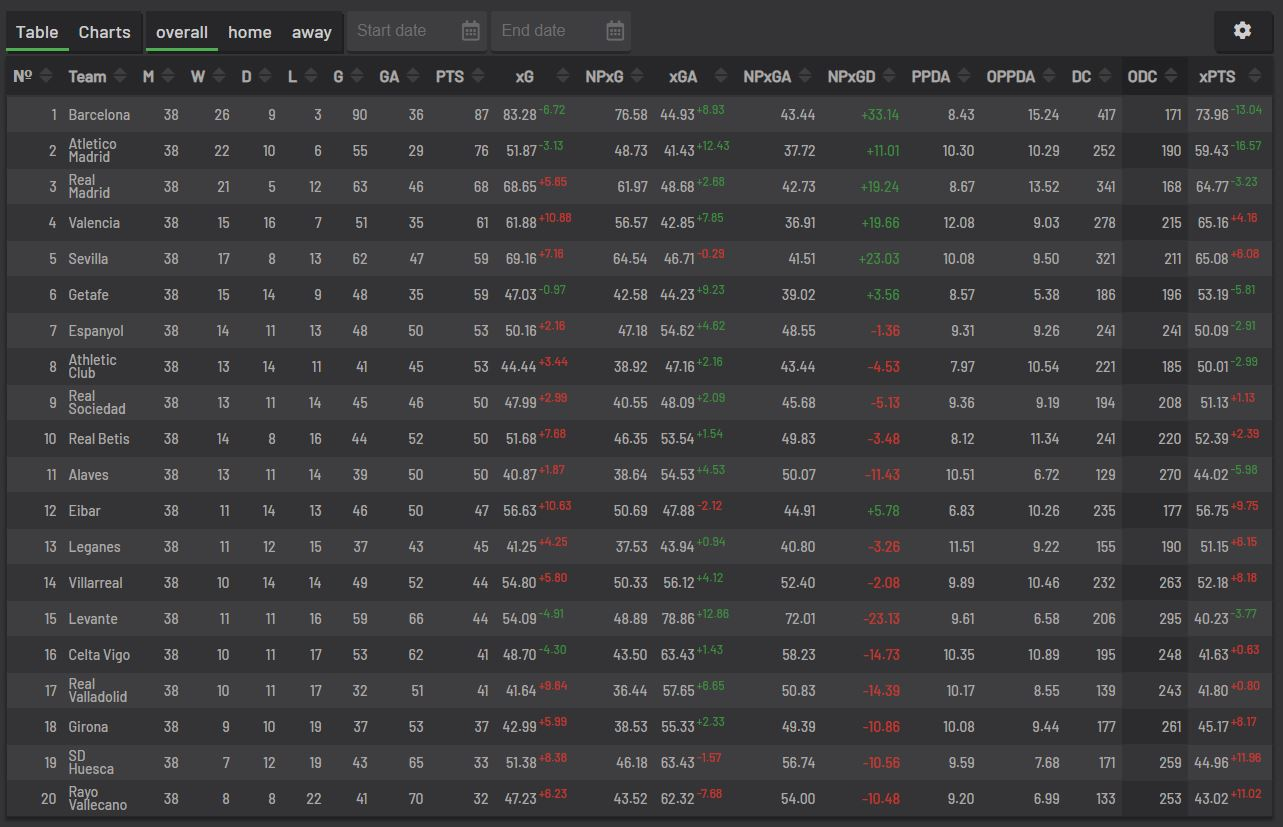

## Scrapping data for all teams of all leagues of all seasons

Testing the flow before going full into the process

In [18]:
season_data = dict()
season_data[seasons[4]] = full_stat
print(season_data)
full_data = dict()
full_data[leagues[0]] = season_data
print(full_data)

{'2018':     position             team  matches  wins  draws  loses  scored  missed  \
0          1        Barcelona       38    26      9      3      90      36   
1          2  Atletico Madrid       38    22     10      6      55      29   
2          3      Real Madrid       38    21      5     12      63      46   
3          4         Valencia       38    15     16      7      51      35   
4          5          Sevilla       38    17      8     13      62      47   
5          6           Getafe       38    15     14      9      48      35   
6          7         Espanyol       38    14     11     13      48      50   
7          8    Athletic Club       38    13     14     11      41      45   
8          9    Real Sociedad       38    13     11     14      45      46   
9         10           Alaves       38    13     11     14      39      50   
10        11       Real Betis       38    14      8     16      44      52   
11        12            Eibar       38    11     14    

Putting all the previous code into loops to get all data.

In [19]:
full_data = dict()
for league in leagues:
  
  season_data = dict()
  for season in seasons:    
    url = base_url+'/'+league+'/'+season
    res = requests.get(url)
    soup = BeautifulSoup(res.content, "lxml")

    # Based on the structure of the webpage, I found that data is in the JSON variable, under <script> tags
    scripts = soup.find_all('script')
    
    string_with_json_obj = ''

    # Find data for teams
    for el in scripts:
        if 'teamsData' in el.text:
          string_with_json_obj = el.text.strip()

    # print(string_with_json_obj)

    # strip unnecessary symbols and get only JSON data
    ind_start = string_with_json_obj.index("('")+2
    ind_end = string_with_json_obj.index("')")
    json_data = string_with_json_obj[ind_start:ind_end]
    json_data = json_data.encode('utf8').decode('unicode_escape')
    
    
    # convert JSON data into Python dictionary
    data = json.loads(json_data)
    
    # Get teams and their relevant ids and put them into separate dictionary
    teams = {}
    for id in data.keys():
      teams[id] = data[id]['title']
      
    # EDA to get a feeling of how the JSON is structured
    # Column names are all the same, so we just use first element
    columns = []
    # Check the sample of values per each column
    values = []
    for id in data.keys():
      columns = list(data[id]['history'][0].keys())
      values = list(data[id]['history'][0].values())
      break
      
    # Getting data for all teams
    dataframes = {}
    for id, team in teams.items():
      teams_data = []
      for row in data[id]['history']:
        teams_data.append(list(row.values()))

      df = pd.DataFrame(teams_data, columns=columns)
      dataframes[team] = df
      # print('Added data for {}.'.format(team))
      
    
    for team, df in dataframes.items():
      dataframes[team]['ppda_coef'] = dataframes[team]['ppda'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
      dataframes[team]['oppda_coef'] = dataframes[team]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
      
    cols_to_sum = ['xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD']
    cols_to_mean = ['ppda_coef', 'oppda_coef']
    
    frames = []
    for team, df in dataframes.items():
      sum_data = pd.DataFrame(df[cols_to_sum].sum()).transpose()
      mean_data = pd.DataFrame(df[cols_to_mean].mean()).transpose()
      final_df = sum_data.join(mean_data)
      final_df['team'] = team
      final_df['matches'] = len(df)
      frames.append(final_df)

    full_stat = pd.concat(frames)
    
    full_stat = full_stat[['team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'npxG', 'xGA', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts']]
    full_stat.sort_values('pts', ascending=False, inplace=True)
    full_stat.reset_index(inplace=True, drop=True)
    full_stat['position'] = range(1,len(full_stat)+1)
    
    full_stat['xG_diff'] = full_stat['xG'] - full_stat['scored']
    full_stat['xGA_diff'] = full_stat['xGA'] - full_stat['missed']
    full_stat['xpts_diff'] = full_stat['xpts'] - full_stat['pts']
    
    cols_to_int = ['wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'deep', 'deep_allowed']
    full_stat[cols_to_int] = full_stat[cols_to_int].astype(int)
    
    col_order = ['position', 'team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'xG_diff', 'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts', 'xpts_diff']
    full_stat = full_stat[col_order]
    full_stat = full_stat.set_index('position')
    # print(full_stat.head(20))
    
    season_data[season] = full_stat
  
  df_season = pd.concat(season_data)
  full_data[league] = df_season
  
data = pd.concat(full_data)
data.head()
  

team  matches  wins  draws  loses  \
                position                                                     
Bundesliga 2014 1               Bayern Munich       34    25      4      5   
                2                   Wolfsburg       34    20      9      5   
                3         Borussia M.Gladbach       34    19      9      6   
                4            Bayer Leverkusen       34    17     10      7   
                5                    Augsburg       34    15      4     15   

                          scored  missed  pts    xG  xG_diff    ...       xGA  \
                position                                        ...             
Bundesliga 2014 1             80      18   79 66.21   -13.79    ...     21.94   
                2             72      38   69 58.35   -13.65    ...     38.82   
                3             53      26   66 51.74    -1.26    ...     36.34   
                4             62      37   61 49.16   -12.84    ...     34.72   
                5             43      43   49 43.91     0.91    ...     46.66   

                          xGA_diff  npxGA  npxGD  ppda_coef  oppda_coef  deep  \
                position                                                        
Bundesliga 2014 1             3.94  20.42  41.24       5.76       25.02   388   
                2             0.82  36.42  18.90       9.14       10.29   172   
                3            10.34  33.31  16.16      12.75       12.78   221   
                4            -2.28  30.17  18.22       5.69        7.35   246   
                5             3.66  43.63  -5.91       7.63       10.40   134   

                          deep_allowed  xpts  xpts_diff  
                position                                 
Bundesliga 2014 1                   83 73.61      -5.39  
                2                  164 59.95      -9.05  
                3                  198 57.01      -8.99  
                4                  108 55.34      -5.66  
                5                  221 45.50      -3.50  

[5 rows x 21 columns]

## Exporting data to CSV file

In [20]:
data.to_csv('understat.com.csv')